# Homogeneous Acoustic Model

The acoustic wave equation is given by 

$$
\frac{\partial^2 u}{\partial t^2} = \frac{c}{\rho} \frac{\partial^2 u}{\partial x^2}
$$

where $c$ and $\rho$ denote the stifness coefficient and the density, respectively. If we subtsitute $u(x,t) = u(x) e^{i \omega t}$ and then divide by $e^{i\omega t}$, we obtain the equation describing the stationary modes:

$$ \label{eq:hom_ac_stat}
-\omega^2 u = \frac{c}{\rho} \frac{\partial^2 u}{\partial x^2}. 
$$

We use the free boundary condition $\frac{\partial u}{\partial x} = 0$ at $x = 0,L$ and the central second order finite difference method to write this as a numerical eigenvalue problem. From this formulation we can find the numerical eigenfrequencies and eigenmodes. 

We now find the analytical solution to equation \eqref{eq:hom_ac_stat}  be used as a benchmark for the results obtained in the numerical method. We can propose a trial solution given as

$$ \label{eq:hom_ac_ansatz}
u = A \cos\left(\sqrt{\frac{\rho}{c}}\omega x\right) + B \sin\left(\sqrt{\frac{\rho}{c}}\omega x\right)
$$

After taking the second derivative with respect to x of our trial solution, we see that it can only satisfy the free boundary condition if:

$$ \label{eq:hom_ac_dispersion}
B = 0 \\
\omega = \sqrt{\frac{c}{\rho}}\pi n / L, \quad n = 1,2,3,...
$$




In [51]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from time import time
import scipy.linalg as la
import scipy.signal as sig

In [52]:
#PARAMETER CHOICES
#stiffness and density
c = 1
rho = 1

#Number of points
N = 100

#Range 
x0 = 0 
x1 = N

#create x array
x = np.linspace(x0,x1,N)

#Determine the spacing
dx = x[1] - x[0]

#Make the matrix using the central finite difference approximation
#inbetween we want the -1, 0, -1 on each row to get the central derivatives
M = -np.eye(N-2,k=-1) + 2*np.eye(N-2) - np.eye(N-2,k=1)
M[0,0] = 1; M[-1,-1] = 1

print(M)

#Scale with the right constant v^2 = c/rho and divide by the discretization 
M*= c/rho/dx**2

[[ 1. -1.  0. ...  0.  0.  0.]
 [-1.  2. -1. ...  0.  0.  0.]
 [ 0. -1.  2. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ...  2. -1.  0.]
 [ 0.  0.  0. ... -1.  2. -1.]
 [ 0.  0.  0. ...  0. -1.  1.]]


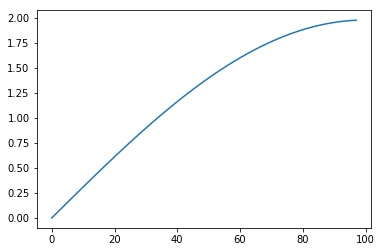

In [53]:
#finding the frequencies and modes
eigenvalues, eigenvectors = np.linalg.eigh(M)
    
#find the eigenvrequencies
frequency = np.sqrt(np.abs(eigenvalues))

#ANALYTIC SOLUTION
#Continuouas analytic dispersion relation
n = np.arange(0, N-2)
frequency_analytic = n*np.sqrt(c/rho)*np.pi/(x1-x0)
#Amplitude A
A = np.max(eigenvectors) * np.sign(eigenvectors[0])
x_ana = np.linspace(x[0], x[-1], 100 * N)
eigenvectors_analytical = A[:,None]*np.cos(n[:,None]* np.pi/(x1-x0)*x_ana)
#Expected 1D laplacian frequencies
discrete_laplc_eigval = np.sqrt(4/dx**2 * c/rho *  np.sin(np.pi*(n)/(2*(N)))**2)

#Discrete analytic dispersion relation
frequency_discrete =  2 / dx * np.sqrt(c/rho) * np.sin(np.pi * n / (2 * N))
plt.plot(n, frequency_discrete)

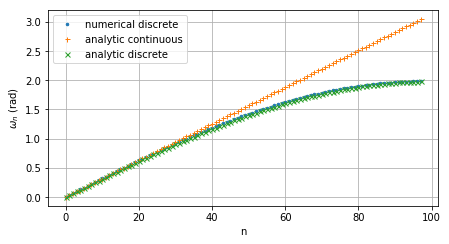

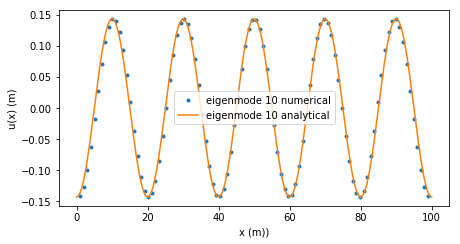

In [60]:
# plot the eigenfrequencies
plt.figure(figsize = (7,3.6))
plt.plot(n, frequency, ls = 'none', marker = '.', markersize = 5, label = "numerical discrete")
plt.plot(n, frequency_analytic, ls = 'none', marker = '+', markersize = 5, label = "analytic continuous")
plt.plot(n, frequency_discrete, ls = 'none', marker = 'x', markersize = 5, label = "analytic discrete")
plt.xlabel("n")
plt.ylabel("$\omega_n$ (rad)")
plt.legend()
plt.grid()
plt.savefig("acoustic_hom_dispersion1.pdf")
plt.show()


k = 10 #plotting index
#assert (k>0 and k<N), f"k should be between 1 and {N}"
plt.figure(figsize = (7,3.6))
plt.plot(x[1:-1], eigenvectors[:,k],label = f"eigenmode {k} numerical", ls = "none", marker = ".")
plt.plot(x_ana, eigenvectors_analytical[k], label = f"eigenmode {k} analytical")
plt.xlabel("x (m))")
plt.ylabel("u(x) (m)")
plt.legend()
plt.show()

## Study of the deviation. Show a few modes

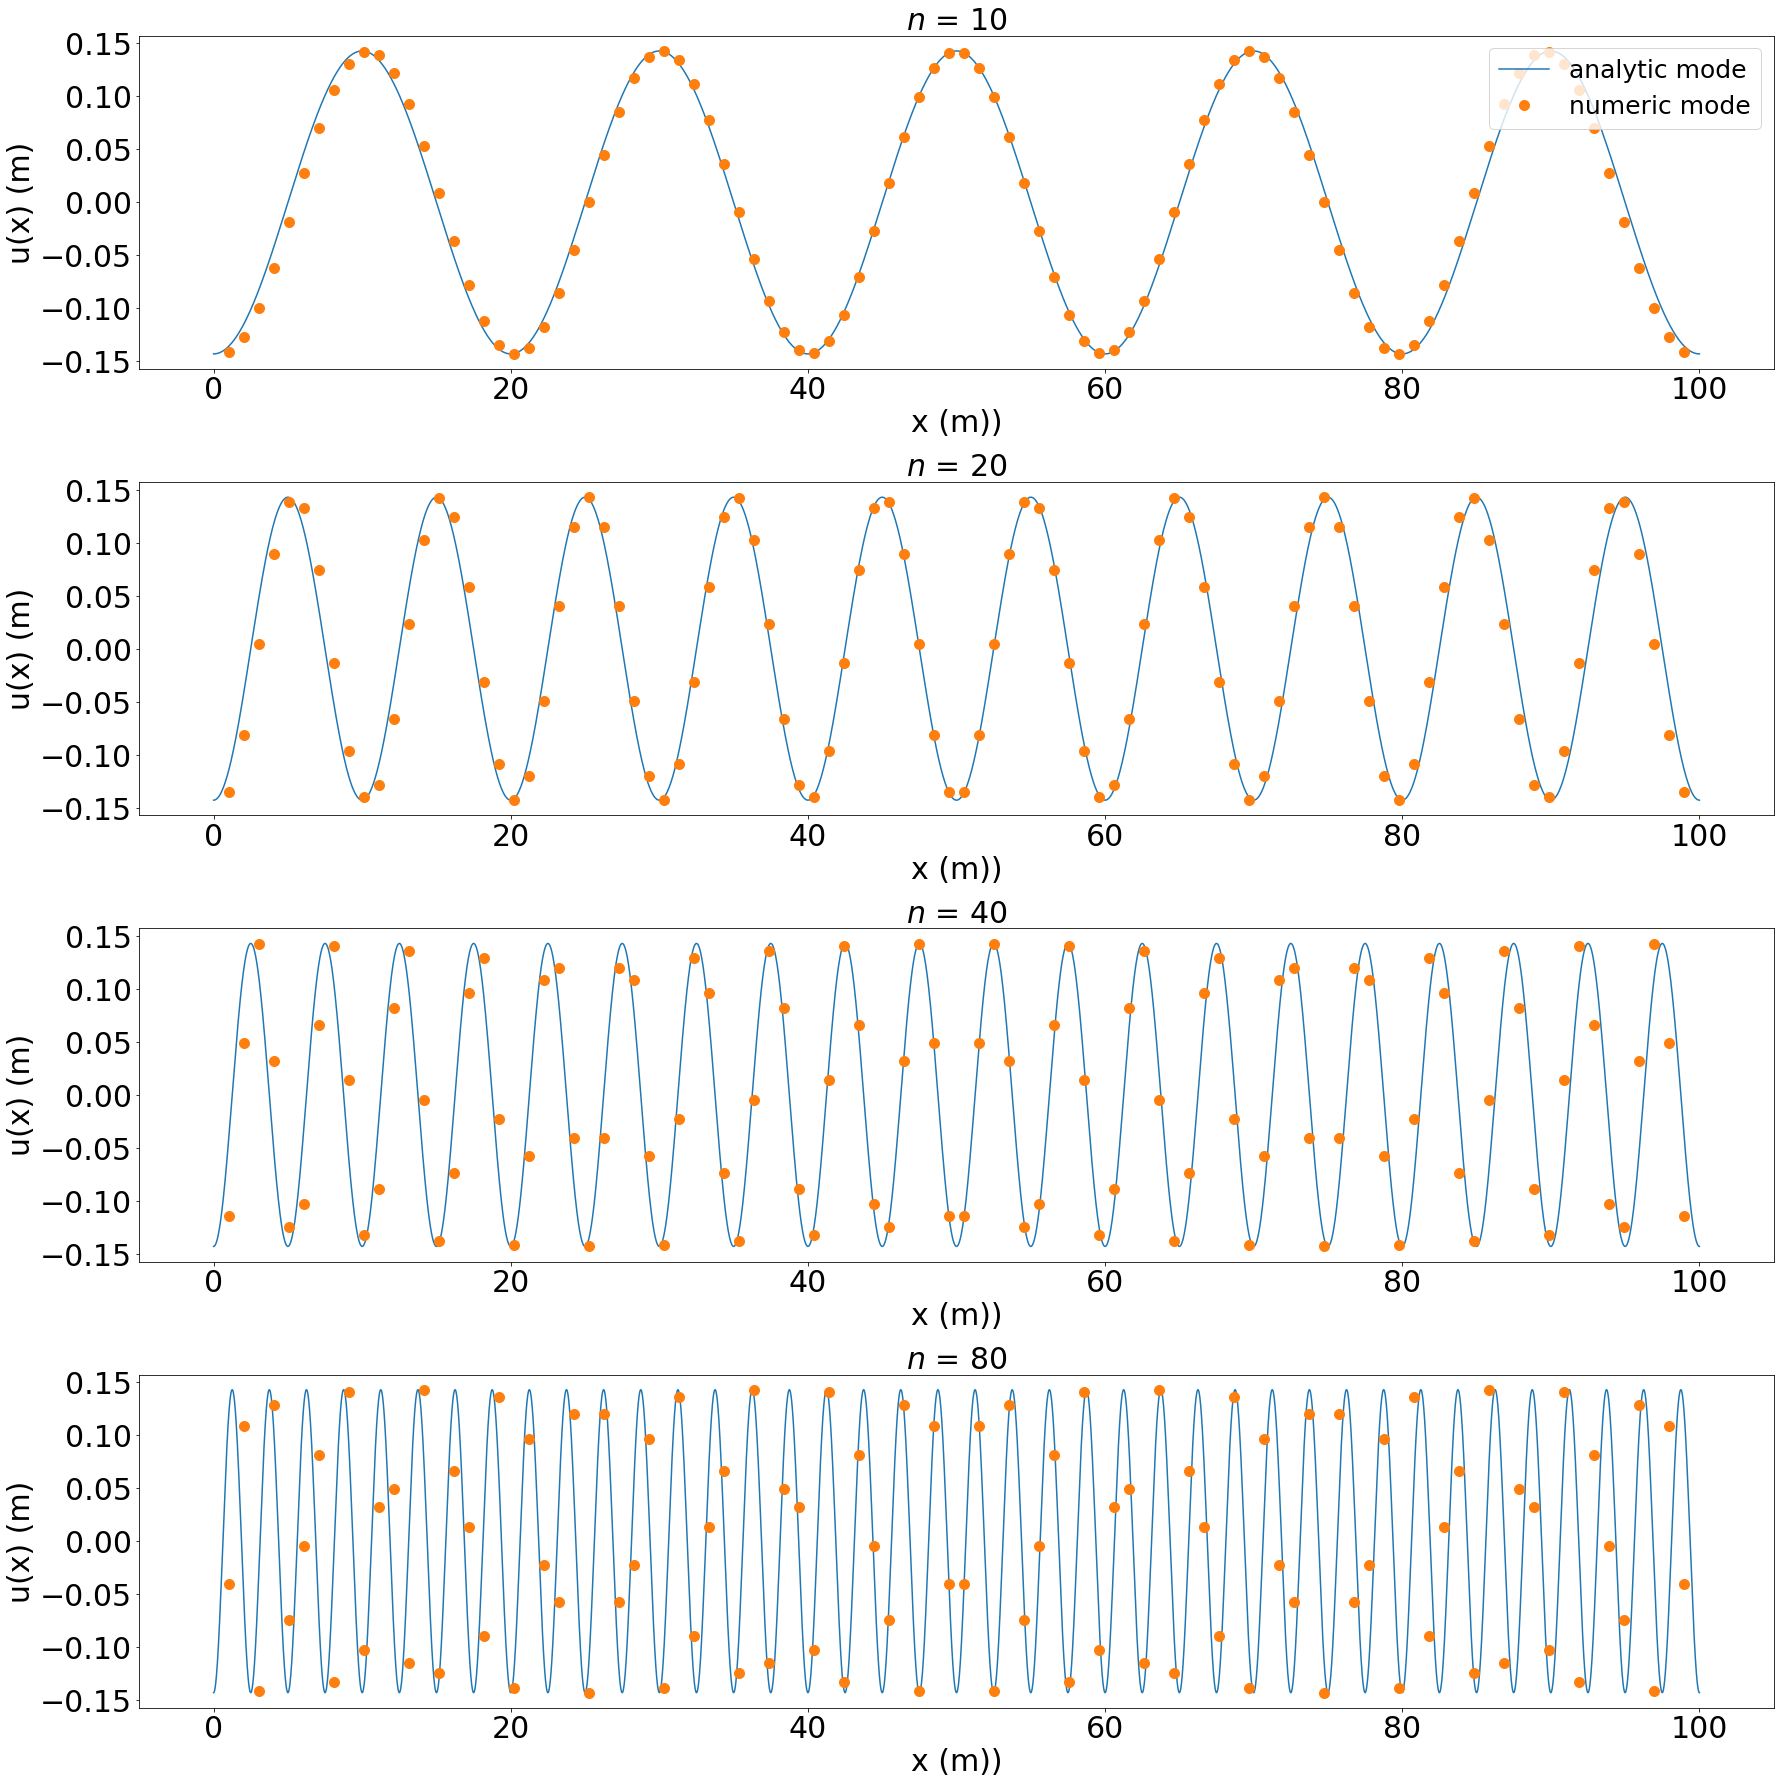

In [62]:
mode_numbers = [10,20,40,80]

figure = plt.figure(figsize = (25,25))

fontsize = 30
for i in range(len(mode_numbers)):
    plt.subplot(len(mode_numbers),1,i+1)
    plt.title(f"$n$ = {mode_numbers[i]}", size = fontsize)
    plt.plot(x_ana, eigenvectors_analytical[mode_numbers[i]], label = "analytic mode")
    plt.plot(x[1:-1], eigenvectors[:,mode_numbers[i]],label = "numeric mode",  lw = 1, marker = ".", ls = "none", markersize = 20)
    plt.xlabel("x (m))", size = fontsize)
    plt.ylabel("u(x) (m)", size = fontsize)
    plt.xticks(size = fontsize)
    plt.yticks(size = fontsize)
    if i == 0: 
        plt.legend(loc = 1, prop={'size': 25})
    #plt.axhline(np.max(eigenvectors[:,mode_numbers[i]]), ls = '--',c = 'red')
    #plt.axhline(np.min(eigenvectors[:,mode_numbers[i]]), ls = '--',c = 'red')
figure.tight_layout(pad=1.5, )
plt.savefig("achom_show_problems.pdf")
plt.show()



#### Brainstorm  of what analyzing incorporates
* Do we get the same answer as the analytical model?
    * Dispersion
        * Analytical model describes a linear slope
            * Interpretation of this slope
        * Do we get the same slope?
        * It seems like we do, but it goes down gradually
            * plot error
            * Why?
            * First guess: We do not have enough points to capture all of the oscillations in the mode
                * Check this by using more points and see if in the end we do actually converge to the analytical solution.
                * Maybe we could even make a calculation of how many oscillations you capture with N points. 
    * Modes
        * Compare the wavelengths
        * Plot error

# Analysis

### Eigenfrequencies
In the analytical solution, we found that the dispersion relation is given by equation \eqref{eq:hom_ac_dispersion}. This is a linear function which is proportional to the velocity $v = \sqrt{\frac{c}{\rho}}$. In the numerical case the analytical and numerical dispersions overlap for the low modes and start to diverge for higher modes. To study the effect of the discretization size on convergence towards the analytical model, we now plot multiple numerically calculated dispersions using logarithmitcally spaced discretization sizes.

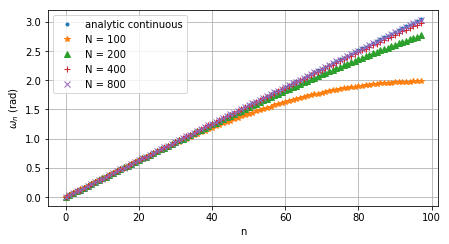

In [71]:
def find_eig(c, rho, x, max_mode):
    #Determine the spacing
    dx = x[1] - x[0]

    #n.o. points
    N = len(x)
    
    assert max_mode <= N-2, "The size of your x array is not long enough to compute the RMSE for this many modes"
    
    #Make the matrix using the central finite difference approximation
    #inbetween we want the -1, 0, -1 on each row to get the central derivatives
    M = -np.eye(N-2,k=-1) + 2*np.eye(N-2) - np.eye(N-2,k=1)
    M[0,0] = 1; M[-1,-1] = 1

    #Scale with the right constant c/rho and divide by the discretization 
    M*= c/rho/dx**2

    #finding the frequencies and modes
    eigenvalues, eigenvectors = np.linalg.eigh(M)

    #find the eigenvrequencies
    frequency = np.sqrt(np.abs(eigenvalues))[:max_mode]
    
    return frequency, eigenvectors

#create an array of RMSE values for different values of N
N = [100,200,400,800]
max_mode = N[0]-2
n = range(max_mode)
#initialize RMSE
plt.figure(figsize=(7,3.6))
plt.plot(n,n*np.sqrt(c/rho)*np.pi/(x1-x0), label = "analytic continuous", ls = "none", marker = '.')
freqs = np.zeros((len(N),max_mode))
#compute the rmse value in a loop
markers = ['*', '^', '+', 'x']
for i in range(len(N)):
    #make x array
    x = np.linspace(x0,x1,N[i])
    
    #compute i'th rmse value
    freqs[i], vec = find_eig(c,rho,x,max_mode)
    
    #plot the frequency for a specific value of N
    plt.plot(n, freqs[i], label= f"N = {N[i]}", ls = "none", marker = markers[i])
plt.xlabel("n")
plt.ylabel("$\omega_n$ (rad)")
plt.legend()
plt.grid()
plt.savefig("acoustic_hom_increase_N.pdf")
plt.show()
    
    
    




In the figure above the analytic dispersion, $n$ versus $\omega$ and several numerically calculated dispersions with different discretization sizes $N$ are depicted. It can be observed that for higher $N$ the numerical dispersion converges towards the analytical dispersion. 

This convergence can be explained from the formula for the eigenvalues of the discretized negative 1D laplacian:

$$
-\frac{\partial^2}{\partial x^2}
$$

For pure neumann boundary conditions, which we have here, the eigenvalues of the negatie 1D laplacian are given as <font color = "blue">(https://en.wikipedia.org/wiki/Eigenvalues_and_eigenvectors_of_the_second_derivative)<font color = "black">:
    
$$ \label{eq:hom_ac_discr_vals}
\mu_{n}=\frac{4}{h^{2}} \sin ^{2}\left(\frac{\pi(n-1)}{2 N}\right)
$$

<font color = "red">Should I add a derivation of this formula? It is given in the wikipedia link<font color = "black">

where $h$ is the discretization step. For small $n$ we can approximate equation \eqref{eq:hom_ac_discr_vals} using the limit 

$$
\lim_{x \to 0} \sin(x) = x 
$$

to obtain that for low modes ($n<<N$),

$$
\mu_n \approx \frac{4}{h^2} \left(\frac{\pi(n-1)}{2N}\right)^2
$$

We can use this to approximate the eigenvalues of the operator 

$$
-\frac{c}{\rho} \frac{\partial^2 }{\partial x^2},
$$

to be given as

$$
\mu_n \approx \frac{c}{\rho} \frac{4}{h^2} \left(\frac{\pi(n-1)}{2N}\right)^2.
$$

The eigenvalues are the square of the the eigenfrequencies. Hence, we can obtain a formula for the eigenfrequencies:

$$
\omega_n \approx \sqrt{\frac{c}{\rho}} \frac{\pi(n-1)}{hN} = \sqrt{\frac{c}{\rho}} \frac{\pi(n-1)}{L}
$$

which reduces to the analytic formula. This derivation demonstrates that our numerical method gives accurate results for the eigenfrequencies when the discretization size is sufficiently large. This agrees with what we observe in figure (above).

<font color = "red">there is a (n-1) vs a n difference<font color = "black">




### Eigenmodes

* Find the wavelength of all of the modes for different values of N
* Compare it to the analytical wavelength of all of the modes

#### Analytical wavelengths
The analytical wavelength is given by 

$$
\lambda_n = \frac{2 L}{n}
$$

so, for $n \geq 2$, we can compare the numerically calculated average wavelength to the analytical expected wavelength for the different mode numbers.

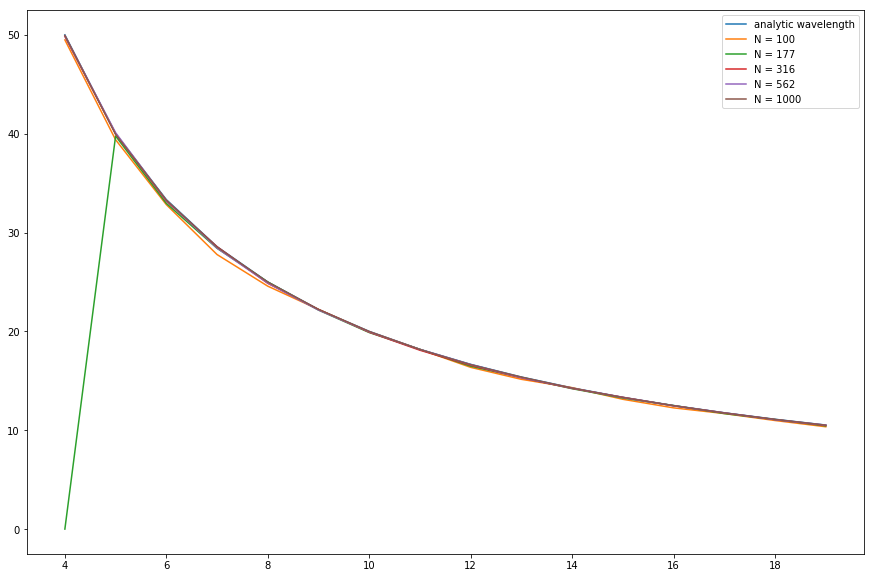

In [7]:
#What do we need to do?

#Take different values of N, maybe the same ones as we did before.
#For that value of N compute all the wavelengths up to an arbitrary maximal mode
#Put them all in one plot to compare them


#create an array of RMSE values for different values of N
N = np.geomspace(100, 1000, 5, dtype = int)
max_mode = 20
start = 4
n = np.arange(start,max_mode)

#initialize RMSE
plt.figure(figsize=(15,10))
plt.plot(n,2 * (x1-x0) / n, label = "analytic wavelength")
#plt.show()
lambdas = np.zeros((len(N),max_mode))



for k in range(len(N)):
    N_k = N[k]
    #find the wavelengths
    x = np.linspace(x0,x1,N_k)
    freqs, vecs = find_eig(c, rho, x, max_mode)
    
    wavelengths_average = np.zeros(max_mode - start)
    for i in range(start,max_mode):
        a = vecs[:,i]
        peaks = sig.find_peaks(a)[0]
        x_peaks = x[peaks+1]
        if len(peaks)>1:
            wavelengths = x_peaks[1:] - x_peaks[:-1]
            wavelengths_average[i-start] = np.average(wavelengths)
    plt.plot(np.arange(start,max_mode), wavelengths_average, label = f"N = {N_k}")
plt.legend()
plt.show()




In [8]:
import numpy as np
x = np.linspace(0,1,7)
print(x)

[0.         0.16666667 0.33333333 0.5        0.66666667 0.83333333
 1.        ]
